# Cocteau Examples
Author: Eve Chase

This notebook provides an example of several basic functions in cocteau

In [1]:
from astropy import units
from astropy.cosmology import Planck18_arXiv_v2
from cocteau import filereaders, observations
from cocteau import observational_utils as utils
import numpy as np


# Read and plot a band
Use the VRO r-band as an example

Effective wavelength: 6220.05 Angstrom


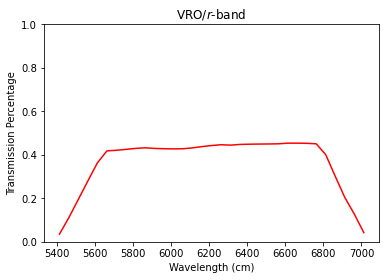

In [2]:
# Initiate FileReader object
fr = filereaders.FileReader()

# Store band filename
band_filename = 'r_VRO.dat'

# Assign a string name to the band
bandname = 'r-band'

# Read in the band, noting the units
band = fr.read_band(band_filename, bandname, 
    wl_units=units.Angstrom)

# Plot the band
ax = band.plot(color='r')
ax.set_title(r'VRO/$r$-band')

# Compute the effective wavelength for the band
wl_eff = band.effective_wavelength()
print(f'Effective wavelength: {wl_eff:.2f}')

# Read in a spectrum
For this example, we'll read in a simulated spectrum from the LANL grid of kilonova simulations (Wollaeger et al. 2021- https://zenodo.org/record/5745556).

Note that each `*.dat` file in the LANL grid contains 54 spectra for the same system, each rendered at a different viewing angle.

Wavelengths: [1.00235e-05 1.00710e-05 1.01190e-05 1.01670e-05 1.02155e-05 1.02640e-05
 1.03125e-05 1.03615e-05 1.04110e-05 1.04605e-05] cm
Flux density: [74.5977   2.62835  9.16651  6.08914  7.86527  3.21554  3.0699   4.3488
 10.4172   5.56802] Ba / s


<AxesSubplot:xlabel='Wavelength (Microns)', ylabel='$\\log_{10}$ dL\\d$\\lambda$  (erg s$^-1 \\AA^{-1}$) + const. '>

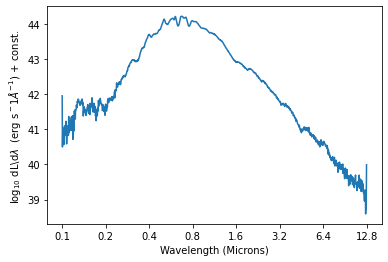

In [3]:
# Set the filename
spectra_filename = 'Run_TS_dyn_all_lanth_wind1_all_md0.001_vd0.3_mw0.1_vw0.05_spec_2020-03-10.dat'

# Initiate a LANL filereader object
fr = filereaders.LANLFileReader()

# Timestep to read spectrum for (must exactly match time in file)
timestep = 2.0 * units.day

# Angle to plot (integer between 0 and 53 for LANL data)
angle = 0

# Read in the spectrum object
spectrum = fr.read_spectrum(spectra_filename, timestep=timestep,
    angle=angle, remove_zero=True)

# Print some parameters of the spectrum
print('Wavelengths:', spectrum.wavelength_arr[:10])
print('Flux density:', spectrum.flux_density_arr[:10])

# Plot the spectrum - need to remove_zero to plot
spectrum.plot()

# Read multiple spectra at the same time
Often it's useful to extract all timesteps simultaneously

In [ ]:
# Get full spectra object for one angle
spectra = fr.read_spectra(spectra_filename, angles=[0],
    remove_zero=True)
print(spectra)

In [ ]:
# Print properties of spectra
spectra[0].timesteps

In [ ]:
# Plot Spectrum at time=2 days
time_idx = np.where(spectra[0].timesteps.value == 2)[0][0]
print(time_idx)

spectra[0].spectra[time_idx].plot()

# Read spectra at all 54 viewing angles 

In [ ]:
# Create spectra objects for all 54 viewing angles
spectra = fr.read_spectra(spectra_filename, 
    angles=np.arange(54), remove_zero=True)
print(spectra)

In [ ]:
# Compare two viewing angles, both at t=2 days
ax = spectra[0].spectra[time_idx].plot(label='Face-on')
ax = spectra[27].spectra[time_idx].plot(ax=ax, label='Edge-on')
ax.legend()

# Compute a magnitude
Using a spectrum and a band, compute a magnitude

In [ ]:
# Compute absolute magnitude
abs_mag = observations.compute_magnitude_at_timestep(spectrum, band,
    num_angles=54).value
print(f'Absolute mag: {abs_mag:.2f}')

# Convert to apparent magnitude at 100 Mpc
dist_lum = 100 * units.Mpc
app_mag = utils.appMag(abs_mag, dist_lum)
print(f'Apparent mag: {app_mag:.2f}')

# Compute a lightcurve
Using a set of time-dependent spectra and a band, compute a lightcurve. Do this for both face-on and edge-on viewing angles

In [ ]:
for angle in [0, 27]:

    # Select spectra to use
    spectra_to_compute = spectra[angle]

    # Create a lightcurve object
    lc = observations.LightCurve(times=spectra_to_compute.timesteps,
        spectra=spectra_to_compute, band=band)
    
    # Plot the lightcurve
    if angle == 0:
        ax = lc.plot(label='On-axis')
    elif angle == 27:
        ax = lc.plot(ax=ax, label='Off-axis')
        
ax.legend()
ax.set_title(r'VRO/$r$-band')
ax.set_ylim(5, None)

# Compute lightcurves at different redshifts
This redshifts the rest-frame spectra

In [ ]:
# Set redshift
redshift = 0.25

# Compute corresponding luminosity distance
dist_lum = Planck18_arXiv_v2.luminosity_distance(redshift)
print(dist_lum)

In [ ]:
# Select spectra to use
spectra_to_compute = spectra[0]

# Create a lightcurve object, supplying the redshift
lc = observations.LightCurve(times=spectra_to_compute.timesteps,
    spectra=spectra_to_compute, band=band, redshift=redshift)

# Plot the lightcurve
ax = lc.plot()
ax.set_title(r'VRO/$r$-band at ' + f'z={redshift:.3f}')